# Curva Característica IV de Módulos Fotovoltaicos

In [1]:
try:
    import photovoltaic as pv
except ImportError:
    !pip install photovoltaic
    import photovoltaic as pv
   
from ipywidgets import interact

try:
    from bokeh.io import push_notebook, show, output_notebook
except ImportError:
    !pip install bokeh
    from bokeh.io import push_notebook, show, output_notebook
    
from bokeh.plotting import figure
output_notebook()

try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt
import numpy as np


Loading BokehJS ...

In [2]:
IL = 0.035 # A/cm²
I0 = 1e-12 # A/cm²
Voc = pv.cell.Voc(IL,I0)
print(f'Voc (V): {Voc:.3f}')

Voc (V): 0.624


## Ideal Solar cell with no resistances

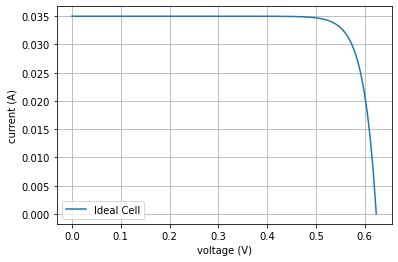

In [3]:
V = np.linspace(0, Voc, 100)
I = pv.cell.I_cell(V, IL, I0)
#plt.ylim(0, 0.04)
plt.xlabel('voltage (V)')
plt.ylabel('current (A)')
plt.grid(True)
plt.plot(V, I, label="Ideal Cell")
plt.legend()
#plt.savefig('plot_ideal_cell.png')
plt.show()

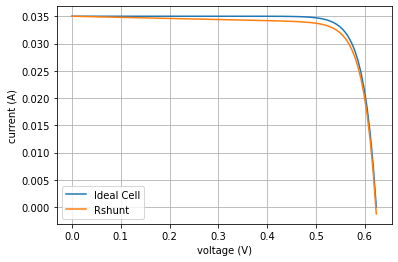

In [4]:
Rshunt = 500 # ohm cm2
I_Rshunt = pv.cell.I_cell_Rshunt(V, IL, I0, Rshunt)
#plt.ylim(0, 0.04)
plt.xlabel('voltage (V)')
plt.ylabel('current (A)')
plt.grid(True)
plt.plot(V, I, label="Ideal Cell")
plt.plot(V, I_Rshunt, label="Rshunt")
plt.legend(loc='lower left')
#plt.savefig('plot_ideal_cell.png')
plt.show()

## Add on series resistance losses

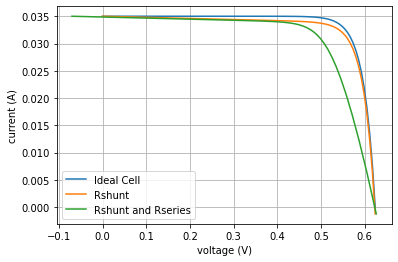

In [5]:
Rseries = 2.0 # ohm cm2
V_Rseries = pv.cell.V_Rseries(V, I_Rshunt, Rseries)
#plt.ylim(0, 0.04)
plt.xlabel('voltage (V)')
plt.ylabel('current (A)')
plt.grid(True)
plt.plot(V, I, label="Ideal Cell")
plt.plot(V, I_Rshunt, label="Rshunt")
plt.plot(V_Rseries, I_Rshunt, label="Rshunt and Rseries")
plt.legend(loc='lower left')
#plt.savefig('plot_ideal_cell.png')
plt.show()

## Tarefa 1

Refaça os gráficos acima incluindo o gráfico da potência. Identifique, também, os pontos de máxima potência, a tensão de circuito aberto e a corrente de curto circuito.

## Definido a Função

Para escrever usando Octave/Matlab

In [6]:
from math import e

def sm55(Va,Rad,TaC):
## ms50.m model for the MS55 solar array
## current given voltage, illumination and temperature
## Ia = ms55(Va,G,TaC) = array voltage
## Ia,Va = array current,voltage
## G = num of Suns (1 Sun = 1000 W/m^2)
## TaC = Temp ambient in Deg C
    if Rad > 5:
        Suns = Rad / 1000
    else:
        Suns = 0.005
    k = 1.38e-23 # Boltzman´s const
    q = 1.60e-19 # charge on an electron
    # enter the following constants here, and the model will be
    # calculated based on these. for 1000W/m^2
    A = 1.9 # "diode quality" factor, =2 for crystaline, <2 for amorphous
    Vg = 1.12 # band gap voltage, 1.12eV for xtal Si, ~1.75 for amorphous Si.
    Ns = 36 # number of series connected cells (diodes)
    T1 = 273 + 25
    Voc_T1 = 21.7 /Ns # open cct voltage per cell at temperature T1
    Isc_T1 = 3.40 # short cct current per cell at temp T1
    T2 = 273 + 60
    Voc_T2 = 18.30 /Ns # open cct voltage per cell at temperature T2
    Isc_T2 = 3.45 # short cct current per cell at temp T2
    TaK = 273 + TaC + 35 * Suns # array working temp
    TrK = 273 + 25 # reference temp
    # when Va = 0, light generated current Iph_T1 = array short cct current
    # constant "a" can be determined from Isc vs T
    Iph_T1 = Isc_T1 * Suns
    a = (Isc_T2 - Isc_T1)/Isc_T1 * 1/(T2 - T1)
    Iph = Iph_T1 * (1 + a*(TaK - T1))
    Vt_T1 = k * T1 / q # = A * kT/q
    Ir_T1 = Isc_T1 / (e**(Voc_T1/(A*Vt_T1))-1)
    Ir_T2 = Isc_T2 / (e**(Voc_T2/(A*Vt_T1))-1)
    b = Vg * q/(A*k)
    Ir = Ir_T1 * (TaK/T1)**(3/A) * e**(-b*(1/TaK - 1/T1))
    X2v = Ir_T1/(A*Vt_T1) * e**(Voc_T1/(A*Vt_T1))
    dVdI_Voc = - 1.15/Ns / 2 # dV/dI at Voc per cell --
    # from manufacturers graph
    Rs = - dVdI_Voc - 1/X2v # series resistance per cell
    # Ia = 0:0.01:Iph
    Vt_Ta = A * k * TaK / q # = A * kT/q
    # Ia1 = Iph - Ir*( e**((Vc+Ia*Rs)/Vt_Ta) -1)
    # solve for Ia: f(Ia) = Iph - Ia - Ir*( e**((Vc+Ia*Rs)/Vt_Ta) -1) = 0
    # Newton´s method: Ia2 = Ia1 - f(Ia1)/f´(Ia1)
    Vc = Va/Ns
    Ia = Vc*0
    # Iav = Ia
    for j in range(5):
        Ia = Ia - (Iph - Ia - Ir*(e**((Vc+Ia*Rs)/Vt_Ta) -1)) / (-1 - (Ir*( e**((Vc+Ia*Rs)/Vt_Ta) -1))*Rs/Vt_Ta)
        # Iav = [Iav;Ia] # to observe convergence for debugging.
    return Ia

## Gráfico interativo

In [7]:
Va = np.linspace(0, 20, 100)
y = np.sin(Va)
p = figure(title="Curva Característica", plot_height=300, plot_width=600, y_range=(0,4), x_range=(0,20),
           background_fill_color='#efefef')
r = p.line(Va, y, color="#8888cc", line_width=1.5, alpha=0.8)

In [8]:
def update(Rad = 1000, TaC = 25):
    r.data_source.data['y'] = sm55(Va,Rad,TaC)
    push_notebook()

In [9]:
show(p, notebook_handle=True)

In [10]:
interact(update, Rad=(0,1300), TaC=(0,70))

<function __main__.update(Rad=1000, TaC=25)>

## Tarefa 2

Faça um gráfico interativo variando os 5 parâmetros elétricos do modelo elétrico de um módulo fotovoltaico. Semelhante ao realizado para as resistências neste site: https://www.pveducation.org/es/fotovoltaica/characterisation/measurement-of-series-resistance